# Bayesian GNNs for Molecular Property Prediction

**In this notebook, we will train Bayesian GNNs and compare their regression performance to GPs.**

We will compare the molecular property prediction performance of Bayesian GNNs, inspired by Hwang et al. 2020 (https://pubs.acs.org/doi/abs/10.1021/acs.jcim.0c00416). The feature extractor used here is the GIN architecture, with the same graph features used in the graph kernel experiments. Here we rely on a final Bayesian linear layers from Bayesian-Torch (https://github.com/IntelLabs/bayesian-torch).

The densely connected final layer will have weight *distributions* rather than deterministic weights. The uncertainty of the model will be obtained by repeatedly sampling the network for predictions. We recommend using the CUDA to increase the speed of training the GNN.

## Install and import dependencies

In [1]:
# install gauche and other dependencies

%%capture
!pip install gauche[graphs] bayesian-torch torch_geometric

In [2]:
import os, sys
sys.path.append('..')
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

# import sklearn
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data

import pandas as pd
import numpy as np
import rdkit.Chem.AllChem as Chem
import matplotlib.pyplot as plt

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops
from bayesian_torch.layers import LinearFlipout, LinearReparameterization

## Featurise Molecules and PyTorch Geometric Graphs

To train GNNs on molecular data, we first need to featurise the molecules and convert them into PyTorch Geometric Data objects. We will represent each molecule as a graph with atoms as nodes and bonds as edges, using element numbers and chirality as node features and bond type and E/Z double bond stereo information as edge labels. To apply this featuriser to the benchmark datasets, we will simply provide it as a custom featuriser to the `MolPropLoader().featurize` function.

In [3]:
# define a custom PyTorch Geometric featuriser that captures
# element number, bond types and chirality

allowable_features = {
    "possible_atomic_num_list": list(range(1, 119)),
    "possible_chirality_list": [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER,
    ],
    "possible_bonds": [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC,
    ],
    # (E)/(Z) double bond stereo information
    "possible_bond_dirs": [
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT,
    ],
}

# define constants for featurisation and embedding
num_atom_type = 120  # including the extra mask tokens
num_chirality_tag = 3
num_bond_type = 6  # including aromatic and self-loop edge, and extra masked tokens
num_bond_direction = 3
self_loop_token = 4  # bond type for self-loop edge
masked_bond_token = 5  # bond type for masked edges


def mol_to_pyg(smiles):
    """
    A featuriser that accepts an smiles STRING and
    converts it to a PyTorch Geometric data object that
    is compatible with the GNN modules below.
    Args:
        smiles: SMILES string
    Returns: PyTorch Geometric data object
    """

    mol = Chem.MolFromSmiles(smiles)

    # derive atom features: atomic number + chirality tag
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(
            [
                allowable_features["possible_atomic_num_list"].index(
                    atom.GetAtomicNum()
                ),
                allowable_features["possible_chirality_list"].index(
                    atom.GetChiralTag()
                ),
            ]
        )
    atom_features = torch.tensor(np.array(atom_features), dtype=torch.long)

    # derive bond features: bond type + bond direction
    # PyTorch Geometric only uses directed edges,
    # so feature information needs to be added twice
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))

        # calculate edge features and append them to feature list
        edge_feature = [
            allowable_features["possible_bonds"].index(bond.GetBondType()),
            allowable_features["possible_bond_dirs"].index(bond.GetBondDir()),
        ]
        edge_attr.append(edge_feature)
        edge_attr.append(edge_feature)

    # set data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)

    # set data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
    edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.long)

    return Data(x=atom_features, edge_index=edge_index, edge_attr=edge_attr)

In [4]:
# load PhotoSwitch dataset and apply mol_to_pyg featuriser

dataset = "Photoswitch"

loader = MolPropLoader()
loader.load_benchmark("Photoswitch")
loader.featurize(lambda smiles: [mol_to_pyg(s) for s in smiles])

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).


## Define GIN Layers and GNN

Next, we need to define the GNN architecture. We will use Graph Isomorphism Network (GIN) convolutions from [Xu et al., How Powerful are Graph Neural Networks?](https://arxiv.org/abs/1810.00826) defined in the `GINConv` class. The `GNN` class stacks multiple `GINConv` layers and applies batch normalisation and a final linear layer to map the node representations to the desired output dimension.

In [5]:
class GINConv(MessagePassing):
    """
    Extension of the Graph Isomorphism Network to incorporate
    edge information by concatenating edge embeddings.
    """

    def __init__(self, emb_dim, aggr="add"):
        """
        Initialise GIN convolutional layer.
        Args:
            emb_dim: latent node embedding dimension
            aggr: aggregation procedure
        """
        super(GINConv, self).__init__()

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 2 * emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * emb_dim, emb_dim),
        )

        self.edge_embedding1 = torch.nn.Embedding(num_bond_type, emb_dim)
        self.edge_embedding2 = torch.nn.Embedding(num_bond_direction, emb_dim)
        torch.nn.init.xavier_uniform_(self.edge_embedding1.weight.data)
        torch.nn.init.xavier_uniform_(self.edge_embedding2.weight.data)

        self.aggr = aggr

    def forward(self, x, edge_index, edge_attr):
        """
        Message passing and aggregation function
        of the adapted GIN convolutional layer.
        Args:
            x: node features
            edge_index: adjacency list
            edge_attr: edge features
        Returns: transformed and aggregated node embeddings
        """

        # add self loops to edge index
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # update edge attributes to represent self-loop edges
        self_loop_attr = torch.zeros(x.size(0), 2)
        self_loop_attr[:, 0] = self_loop_token
        self_loop_attr = self_loop_attr.to(edge_attr.device).to(
            edge_attr.dtype
        )
        edge_attr = torch.cat((edge_attr, self_loop_attr), dim=0)

        # generate edge embeddings and propagate
        edge_embeddings = self.edge_embedding1(
            edge_attr[:, 0]
        ) + self.edge_embedding2(edge_attr[:, 1])
        return self.propagate(edge_index, x=x, edge_attr=edge_embeddings)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)


class GNN(torch.nn.Module):
    """
    Combine multiple GNN layers into a network.
    """

    def __init__(self, num_layers=5, embed_dim=300, gnn_type="gin"):
        """
        Compose convolution layers into GNN. Pretrained parameters
        exist for a 5-layer network with 300 hidden units.
        Args:
            num_layers: number of convolution layers
            embed_dim: dimension of node embeddings
            gnn_type: type of convolutional layer to use
        """

        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.gnn_type = gnn_type

        super(GNN, self).__init__()

        # initialise label embeddings
        self.x_embedding1 = torch.nn.Embedding(num_atom_type, self.embed_dim)
        self.x_embedding2 = torch.nn.Embedding(
            num_chirality_tag, self.embed_dim
        )
        torch.nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        torch.nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        # initialise GNN layers
        self.gnns = torch.nn.ModuleList()
        for layer in range(self.num_layers):
            if gnn_type == "gin":
                self.gnns.append(GINConv(emb_dim=self.embed_dim))
            else:
                raise NotImplementedError("Invalid GNN layer type.")

        # initialise BatchNorm layers
        self.batch_norms = torch.nn.ModuleList()
        for layer in range(self.num_layers):
            self.batch_norms.append(torch.nn.BatchNorm1d(self.embed_dim))

    def forward(self, x, edge_index, edge_attr):
        """
        Forward function of the GNN class that takes a PyTorch geometric
        representation of a molecule or a batch of molecules
        and generates the node embeddings for each atom.
        Args:
            x: node features
            edge_index: adjacency list
            edge_attr: edge features
        Returns: tensor of num_nodes x embedding_dim embeddings
        """

        # x[:, 0] corresponds to 'possible_atomic_num_list',
        # x[:, 1] corresponds to 'possible_chirality_list'
        x = self.x_embedding1(x[:, 0]) + self.x_embedding2(x[:, 1])

        for layer in range(self.num_layers):
            # x are atom features of the molecule and edge_attr the atomic features of the molecule
            x = self.gnns[layer](x, edge_index, edge_attr)
            x = self.batch_norms[layer](x)
            if layer != self.num_layers - 1:
                x = F.relu(x)

        return x

## Construct the Bayesian GNN module and define the training and evaluation protocol

Finally, we will define the Bayesian GNN module that takes the node-wise representations from the GNN, combines them into a graph-level representation and applies the `LinearReparameterization` layer from `bayesian_torch` to define the final Bayesian linear layer. We will also define the training and evaluation protocol for the Bayesian GNNs: These are similar to the ones you might use for deterministic GNNs, with the difference that we can draw multiple sample from the distribution over network weights to obtain predictions and uncertainty estimates.

In [6]:
class BayesianGNN(nn.Module):
    def __init__(self, embed_dim=300, num_layers=5, gnn_type='gin', output_dim=1):
        super().__init__()
        self.gnn = GNN(num_layers=num_layers, embed_dim=embed_dim, gnn_type=gnn_type)
        self.pooling = global_mean_pool
        self.bayes_layer = LinearReparameterization(embed_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        res = self.gnn(x, edge_index, edge_attr)
        res = self.pooling(res, batch)

        # bayesian layer
        kl_sum = 0
        res, kl = self.bayes_layer(res)
        kl_sum += kl
        return res, kl_sum

In [7]:
def nlpd(y, y_pred, y_std):
    nld = 0
    for y_true, mu, std in zip(y.ravel(), y_pred.ravel(), y_std.ravel()):
        nld  += -norm(mu, std).logpdf(y_true)
    return nld / len(y)

def predict(regressor, X, samples = 100):
    preds = [regressor(X)[0] for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    var = preds.var(axis=0)
    return means, var

def graph_append_label(X, y, device):
    G = []
    for g, label in zip(X, y):
        g.y = label
        g = g.to(device)
        G.append(g)
    return G

In [8]:
def evaluate_model(X, y, n_epochs=100, n_trials=20, kld_beta = 1., verbose=True):
    test_set_size = 0.2
    batch_size = 32

    r2_list = []
    rmse_list = []
    mae_list = []
    nlpd_list = []

    # We pre-allocate array for plotting confidence-error curves

    _, y_test = train_test_split(y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)

    mae_confidence_list = np.zeros((n_trials, n_test))

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Device being used: {device}')

    print('\nBeginning training loop...')

    for i in range(0, n_trials):

        print(f'Starting trial {i}')

        # split data and perform standardization
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)
        _, y_train, _, y_test, y_scaler = transform_data(y_train, y_train, y_test, y_test)

        # include y in the pyg graph structure
        G_train = graph_append_label(X_train, y_train, device)
        G_test = graph_append_label(X_test, y_test, device)

        dataloader_train = DataLoader(G_train, batch_size=batch_size, shuffle=True, drop_last=True)
        dataloader_test = DataLoader(G_test, batch_size=len(G_test))

        # initialize model and optimizer
        model = BayesianGNN(gnn_type='gin').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.MSELoss()

        training_loss = []

        status = {}
        best_loss = np.inf
        patience = 50
        count = 0
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            running_kld_loss = 0
            running_mse_loss = 0
            running_loss = 0
            for data in dataloader_train:
                optimizer.zero_grad()

                output, kl = model(data)

                # calculate loss with kl term for Bayesian layers
                target = torch.tensor(np.array(data.y), dtype=torch.float, device=device)
                mse_loss = criterion(output, target)
                loss = mse_loss + kl * kld_beta / batch_size

                loss.backward()
                optimizer.step()

                running_mse_loss += mse_loss.detach().cpu().numpy()
                running_kld_loss += kl.detach().cpu().numpy()
                running_loss += loss.detach().cpu().numpy()

            status.update({
                'Epoch': epoch,
                'loss': running_loss/len(dataloader_train),
                'kl': running_kld_loss/len(dataloader_train),
                'mse': running_mse_loss/len(dataloader_train)
            })
            training_loss.append(status)
            pbar.set_postfix(status)

            with torch.no_grad():
                for data in dataloader_test:
                    y_pred, y_var = predict(model, data)
                    target = torch.tensor(np.array(data.y), dtype=torch.float, device=device)
                    val_loss = criterion(y_pred, target)
                    val_loss = val_loss.detach().cpu().numpy()
                    status.update({'val_loss': val_loss})

                if best_loss > val_loss:
                    best_loss = val_loss
                    best_model = copy.deepcopy(model)
                    count = 0
                else:
                    count += 1

                if count >= patience:
                    if verbose: print(f'Early stopping reached! Best validation loss {best_loss}')
                    break

            pbar.set_postfix(status)

        # Get into evaluation (predictive posterior) mode
        model = best_model
        model.eval()

        with torch.no_grad():
            # mean and variance by sampling
            for data in dataloader_test:
                y_pred, y_var = predict(model, data, samples=100)
                y_pred = y_pred.detach().cpu().numpy()
                y_var = y_var.detach().cpu().numpy()

        uq_nlpd = nlpd(y_test, y_pred, np.sqrt(y_var))
        if verbose: print(f'NLPD: {uq_nlpd}')

        # Transform back to real data space to compute metrics and detach gradients.
        y_pred = y_scaler.inverse_transform(y_pred)
        y_test = y_scaler.inverse_transform(y_test)

        # Compute scores for confidence curve plotting.
        ranked_confidence_list = np.argsort(y_var, axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence
            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)
        nlpd_list.append(uq_nlpd)

    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)
    nlpd_list = np.array(nlpd_list)

    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list))))
    print("mean NLPD: {:.4f} +- {:.4f}\n".format(np.mean(nlpd_list), np.std(nlpd_list)/np.sqrt(len(nlpd_list))))
    print()

    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std

    fig = plt.figure()
    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])

    results = {
        'confidence_percentiles': confidence_percentiles,
        'mae_mean': mae_mean,
        'mae_std': mae_std,
        'mae': mae_list,
        'rmse': rmse_list,
        'r2': r2_list,
        'nlpd': nlpd_list,
    }

    return results, fig


## Run the training and evaluation loop

Device being used: cuda

Beginning training loop...
Starting trial 0


 47%|████▋     | 142/300 [02:00<02:14,  1.18it/s, Epoch=142, loss=3.74, kl=1.33, mse=1.66, val_loss=0.30306697]

Early stopping reached! Best validation loss 0.11581621319055557


NLPD: 0.7891262299567953
Starting trial 1


 69%|██████▊   | 206/300 [02:35<01:11,  1.32it/s, Epoch=206, loss=3.04, kl=1.03, mse=1.43, val_loss=0.19800645]

Early stopping reached! Best validation loss 0.1911984235048294


NLPD: 0.9329165919360254
Starting trial 2


 35%|███▍      | 104/300 [01:19<02:29,  1.31it/s, Epoch=104, loss=3.31, kl=1.7, mse=0.646, val_loss=0.29850987]

Early stopping reached! Best validation loss 0.22155441343784332


NLPD: 0.9101015414270804
Starting trial 3


 24%|██▍       | 72/300 [00:55<02:54,  1.30it/s, Epoch=72, loss=4.45, kl=1.89, mse=1.49, val_loss=0.1720525]

Early stopping reached! Best validation loss 0.15270735323429108


NLPD: 0.513528300588651
Starting trial 4


 22%|██▏       | 66/300 [00:50<03:00,  1.30it/s, Epoch=66, loss=3.92, kl=1.73, mse=1.22, val_loss=0.5326283]

Early stopping reached! Best validation loss 0.3228945732116699


NLPD: 1.683367726229072
Starting trial 5


 53%|█████▎    | 158/300 [02:02<01:50,  1.29it/s, Epoch=158, loss=3.21, kl=1.09, mse=1.5, val_loss=0.3413453]

Early stopping reached! Best validation loss 0.2585623860359192


NLPD: 0.9266979137971999
Starting trial 6


 30%|███       | 91/300 [01:08<02:38,  1.32it/s, Epoch=91, loss=3.96, kl=1.75, mse=1.21, val_loss=0.38592163]

Early stopping reached! Best validation loss 0.2153647243976593


NLPD: 0.6858583467681377
Starting trial 7


 53%|█████▎    | 158/300 [01:59<01:47,  1.32it/s, Epoch=158, loss=2.86, kl=1.22, mse=0.95, val_loss=0.32246053]

Early stopping reached! Best validation loss 0.1867567002773285


NLPD: 0.996825519470283
Starting trial 8


100%|██████████| 300/300 [03:47<00:00,  1.32it/s, Epoch=299, loss=2.2, kl=0.876, mse=0.828, val_loss=0.25577274]


NLPD: 1.02045369536678
Starting trial 9


 25%|██▌       | 75/300 [00:56<02:50,  1.32it/s, Epoch=75, loss=3.63, kl=1.99, mse=0.516, val_loss=0.24762282]

Early stopping reached! Best validation loss 0.16555529832839966


NLPD: 0.5259638768835783

mean R^2: 0.7894 +- 0.0227
mean RMSE: 29.7135 +- 1.3321
mean MAE: 21.4297 +- 0.9820

mean NLPD: 0.8985 +- 0.0993




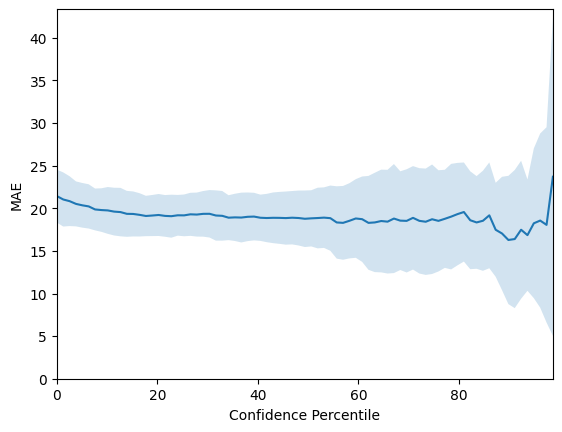

In [9]:
results, fig = evaluate_model(loader.features, loader.labels, n_epochs=300, n_trials=10, kld_beta=50.0)
fig.show()

For graph features input, the results for the Bayesian GNN are below for the various datasets:

| |Photoswitch | Freesolv | ESOL | Lipophilicity |
|---|---|---|---|---|
| R2 | 0.8048 +- 0.0155 | 0.7884 +- 0.0056 | 0.8224 +- 0.0044 | 0.6208 +- 0.0199 |
| RMSE | 28.5302 +- 1.2050 | 0.9610 +- 0.0148  | 0.8800 +- 0.0098 |  0.7317 +- 0.0175 |
| MAE | 20.7182 +- 0.9928 | 0.7264 +- 0.0161 | 0.6622 +- 0.0079 | 0.5328 +- 0.0111 |
| NLPD | 0.9960 +- 0.1286 | 1.0060 +- 0.0153 | 1.6990 +- 0.1085 | 1.1406 +- 0.0120 |
